In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 


os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tqdm
import glob
import tensorflow 
import scipy
import PIL
import six

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import gray2rgb

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=30, zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                                   validation_split = 0.2)

In [3]:
valid_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [4]:
test_datagen  = ImageDataGenerator(rescale = 1./255)

In [5]:
train_dataset  = train_datagen.flow_from_directory(directory = 'Alzheimer_sDataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 128)

Found 4098 images belonging to 4 classes.


In [6]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'Alzheimer_sDataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 128)

Found 1023 images belonging to 4 classes.


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.27s/it]


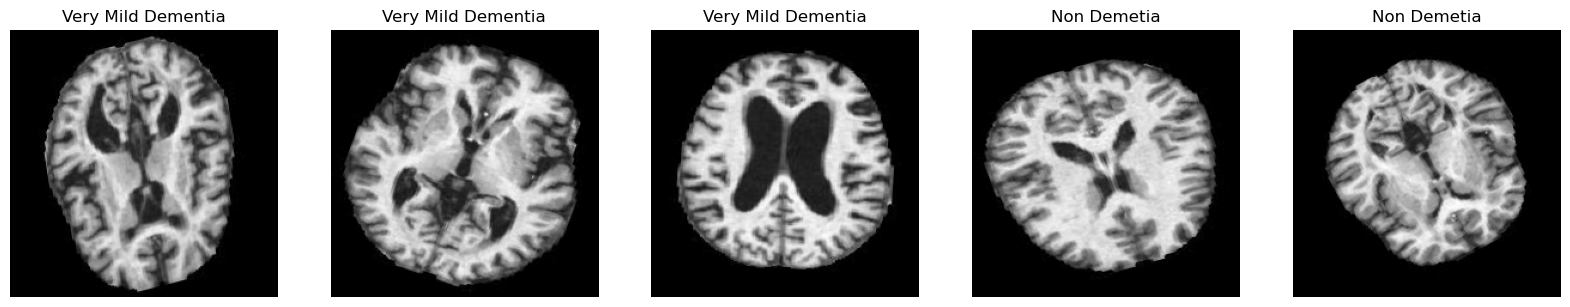

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(20,20))

for i in tqdm(range(0,5)):
    rand1 = np.random.randint(len(train_dataset))
    rand2 = np.random.randint(100)
    ax[i].imshow(train_dataset[rand1][0][rand2])
    ax[i].axis('off')
    a = train_dataset[rand1][1][rand2]
    if a[0] == 1:
        ax[i].set_title('Mild Dementia')
    elif a[1] == 1:
        ax[i].set_title('Moderate Dementia')
    elif a[2] == 1:
        ax[i].set_title('Non Demetia')
    elif a[3] == 1:
        ax[i].set_title('Very Mild Dementia')

In [8]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), include_top=False, weights="imagenet")

In [9]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [10]:
# Building Model

model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(2048,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

In [11]:
# Summary

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (BatchN  (None, 81536)            326144    
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 2048)              166987776 
                                                                 
 batch_normalization_1 (Batc  (None, 2048)             8192      
 hNormalization)                                        

In [12]:
# Model Compile 

OPT    = tensorflow.keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=[tensorflow.keras.metrics.AUC(name = 'auc')],
              optimizer=OPT)

C:\Users\prati\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Defining Callbacks

filepath = './best_weights.h5'

In [14]:
earlystopping = EarlyStopping(monitor = 'val_auc', 
                              mode = 'max' , 
                              patience = 15,
                              verbose = 1)


In [15]:
checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_auc', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

In [16]:
callback_list = [earlystopping, checkpoint]

In [17]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 35,
                        callbacks = callback_list,
                        verbose = 1)

Epoch 1/35
33/33 [==============================] - ETA: 0s - loss: 1.3489 - auc: 0.7879 
Epoch 1: val_auc improved from -inf to 0.73750, saving model to .\best_weights.h5
33/33 [==============================] - 1676s 51s/step - loss: 1.3489 - auc: 0.7879 - val_loss: 3.0957 - val_auc: 0.7375
Epoch 2/35
33/33 [==============================] - ETA: 0s - loss: 1.1084 - auc: 0.8281  
Epoch 2: val_auc improved from 0.73750 to 0.77336, saving model to .\best_weights.h5
33/33 [==============================] - 2762s 85s/step - loss: 1.1084 - auc: 0.8281 - val_loss: 1.8653 - val_auc: 0.7734
Epoch 3/35
33/33 [==============================] - ETA: 0s - loss: 0.9833 - auc: 0.8486 
Epoch 3: val_auc did not improve from 0.77336
33/33 [==============================] - 2056s 63s/step - loss: 0.9833 - auc: 0.8486 - val_loss: 1.8121 - val_auc: 0.7711
Epoch 4/35
33/33 [==============================] - ETA: 0s - loss: 0.9461 - auc: 0.8583 
Epoch 4: val_auc did not improve from 0.77336
33/33 [=======

Epoch 32/35
33/33 [==============================] - ETA: 0s - loss: 0.5242 - auc: 0.9497
Epoch 32: val_auc did not improve from 0.83817
33/33 [==============================] - 363s 11s/step - loss: 0.5242 - auc: 0.9497 - val_loss: 1.6397 - val_auc: 0.7838
Epoch 33/35
33/33 [==============================] - ETA: 0s - loss: 0.5112 - auc: 0.9519
Epoch 33: val_auc did not improve from 0.83817
33/33 [==============================] - 361s 11s/step - loss: 0.5112 - auc: 0.9519 - val_loss: 1.2441 - val_auc: 0.8335
Epoch 34/35
33/33 [==============================] - ETA: 0s - loss: 0.5250 - auc: 0.9496
Epoch 34: val_auc did not improve from 0.83817
33/33 [==============================] - 360s 11s/step - loss: 0.5250 - auc: 0.9496 - val_loss: 1.5037 - val_auc: 0.8185
Epoch 35/35
33/33 [==============================] - ETA: 0s - loss: 0.5039 - auc: 0.9530
Epoch 35: val_auc did not improve from 0.83817
33/33 [==============================] - 358s 11s/step - loss: 0.5039 - auc: 0.9530 - val

# MODEL EVALUATION

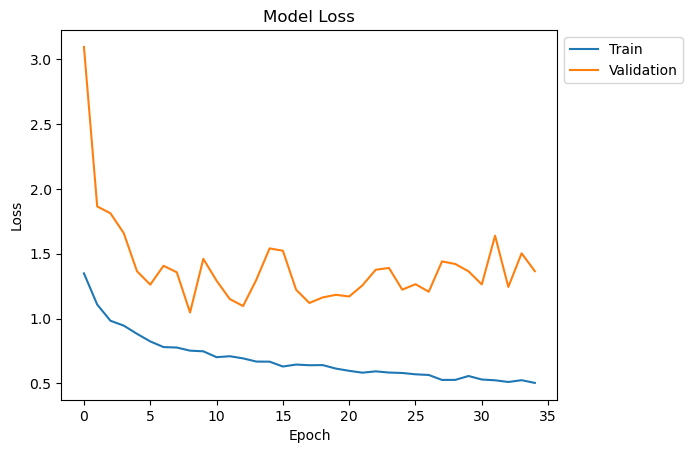

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

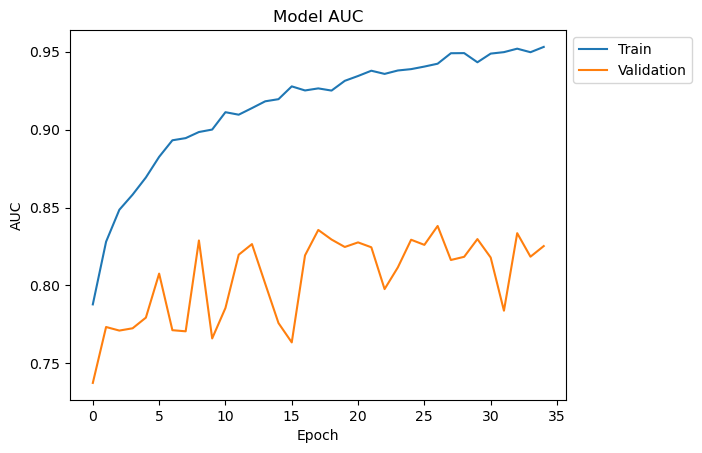

In [19]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [21]:
# Test Data 

test_dataset  = test_datagen.flow_from_directory(directory = 'Alzheimer_sDataset/test',
                                                 target_size = (224,224),
                                                 class_mode = 'categorical',
                                                 batch_size = 128)

Found 1279 images belonging to 4 classes.


In [22]:
# Evaluating Loss and AUC

model.evaluate(test_dataset)

10/10 [==============================] - 78s 8s/step - loss: 1.1472 - auc: 0.8768


[1.1471539735794067, 0.8767818808555603]

1/1 [==============================] - 0s 175ms/step
99.74 % chances are there that the image is NonDemented


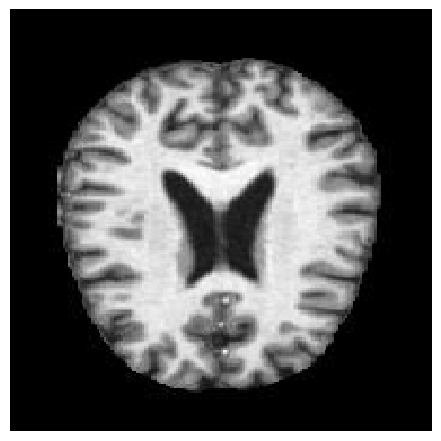

In [34]:
# Test Case 1: Non-Dementia

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_sDataset/test/NonDemented/26 (100).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
classes_x=np.argmax(answer,axis=1)
prob = model.predict(img)
probability = round(np.max(prob*100),2)

print(probability, '% chances are there that the image is',idc[classes_x[0]])

1/1 [==============================] - 0s 147ms/step
85.71 % chances are there that the image is MildDemented


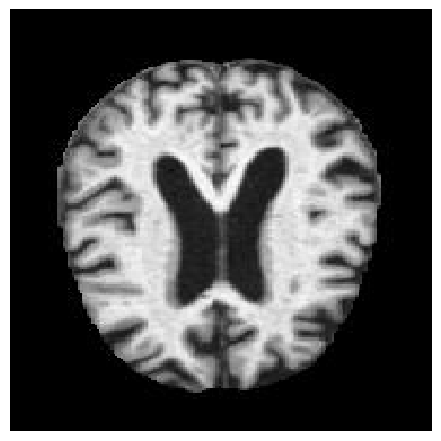

In [38]:
# Test Case 2: Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_sDataset/test/MildDemented/26 (19).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
classes_x=np.argmax(answer,axis=1)
prob = model.predict(img)
probability = round(np.max(prob*100),2)

print(probability, '% chances are there that the image is',idc[classes_x[0]])

1/1 [==============================] - 0s 135ms/step
93.43 % chances are there that the image is ModerateDemented


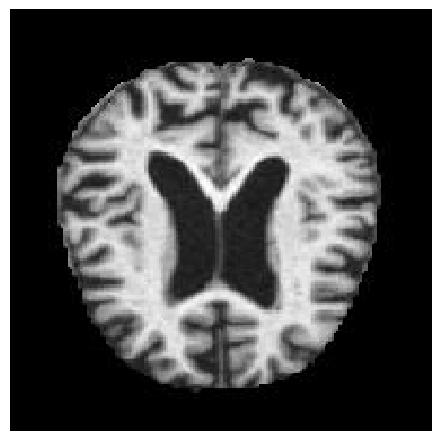

In [40]:
# Test Case 3: Moderate Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_sDataset/test/ModerateDemented/27 (2).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
classes_x=np.argmax(answer,axis=1)
prob = model.predict(img)
probability = round(np.max(prob*100),2)

print(probability, '% chances are there that the image is',idc[classes_x[0]])

1/1 [==============================] - 0s 149ms/step
70.55 % chances are there that the image is MildDemented


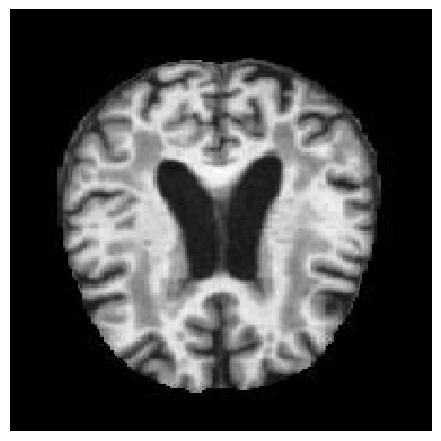

In [42]:
# Test Case 4: Very Mild Demented

dic = test_dataset.class_indices
idc = {k:v for v, k in dic.items()}

img = load_img('Alzheimer_sDataset/test/VeryMildDemented/26 (55).jpg', target_size = (224,224,3))
img = img_to_array(img)
img = img/255
imshow(img)
plt.axis('off')
img = np.expand_dims(img,axis=0)
answer = model.predict(img)
classes_x=np.argmax(answer,axis=1)
prob = model.predict(img)
probability = round(np.max(prob*100),2)


print(probability, '% chances are there that the image is',idc[classes_x[0]])